In [1]:
from itertools import count
from collections import namedtuple
import os
import gc
import time
import pandas as pd
import numpy as np
import zmq
import DRL_pb2

from datetime import date
from agent.main import Agent
from agent.actorcritic import OUNoise
from emulator.main import Account

from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from params import *

orderType = namedtuple("order",
                    ['contract', 'direction', 'volume', 'openOrClose','price'])
order = []
def append_order(*args):
    order.append(orderType(*args))
    
trackType = namedtuple("track",
                    ['contract', 'his_sharpe', 'action', 'TotalPnL', 'dailyPnL'])
track = []
def append_track(*args):
    track.append(trackType(*args))

import per


time to oSD days
1
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2
time to oSD days
1
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2
time to oSD days
1
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2
1.0


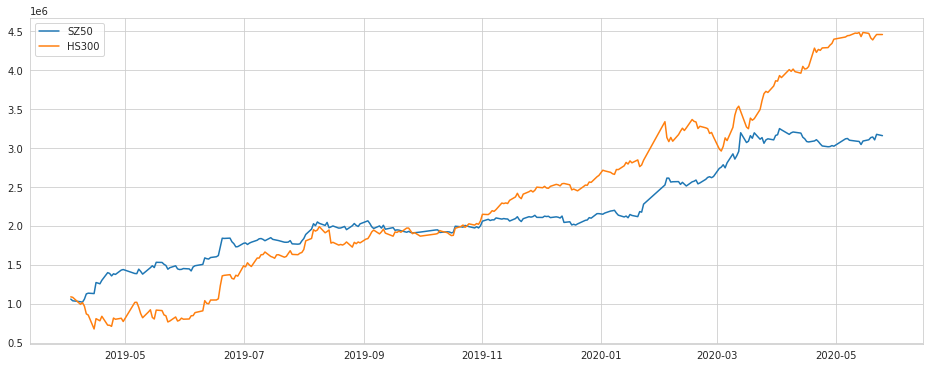

In [2]:
ret = pd.DataFrame()
plt.figure(figsize=(16, 6))
plt_mat = []

instrument = ['SZ50', 'HS300', 'ZZ500']
instrument_contract_mapping = {'SZ50': '沪指50',\
                              'HS300': '沪深300',\
                              'ZZ500': '中证500'}

for _ in instrument:
    env = Account(oSD, date.today().strftime('%Y-%m-%d'), _)
    state = env.reset()
    image_shape = state.shape
    #print(env.data_observation.shape[0])
    Full_Size = env.data_observation.shape[0] - 1
    agent_t = Agent(image_shape, ACTION_SIZE)
    
    try:
        agent_t.load_product_model(_)
    except:
        continue
        
    for i in range(Full_Size):
        action = agent_t.get_exploration_policy(np.expand_dims(state, 0))
        next_state, reward, done = env.step(action, _)
        state = next_state
    
    tmp = env.plot_data()
    ret[_] = tmp.iloc[:, 0]
    
    p1,  = plt.plot(tmp.value)
    plt_mat.append(p1)
    sharpe = np.mean(tmp['reward'])/np.std(tmp['reward'])
    
    contract = instrument_contract_mapping[_]
    
    action_flag = lambda action_flag : 'long' if action_flag > 0 else 'short'
    direction = action_flag(tmp['action'].iloc[-1])
    volume = round(agent_t.get_exploration_policy(np.expand_dims(state, 0)) * Instrument_Clip_Limit[_])
    openOrClose = 'open'
    price = env.data_close[-1]
    append_order(contract, direction, volume, openOrClose, price)
    
    his_sharpe = np.mean(tmp['reward'])/np.std(tmp['reward'])
    action = action_flag(tmp['action'].iloc[-1])
    TotalPnL = round(abs(tmp['action'].iloc[-1]))
    states = env.data_close[-1]
    append_track(contract, sharpe, tmp['action'].iloc[-1], tmp['value'].iloc[-1], tmp['value'].iloc[-1] - tmp['value'].iloc[-2])
    
    action = agent_t.get_exploration_policy(np.expand_dims(state, 0))

plt.legend(plt_mat, instrument ,loc = 'upper left')
tracklist = pd.DataFrame(track)
tracklist
print(action)

In [3]:
orderlist = pd.DataFrame(order)
orderlist

,contract,direction,volume,openOrClose,price
0,沪指50,short,4.0,open,2789.7095
1,沪深300,long,4.0,open,3829.3245


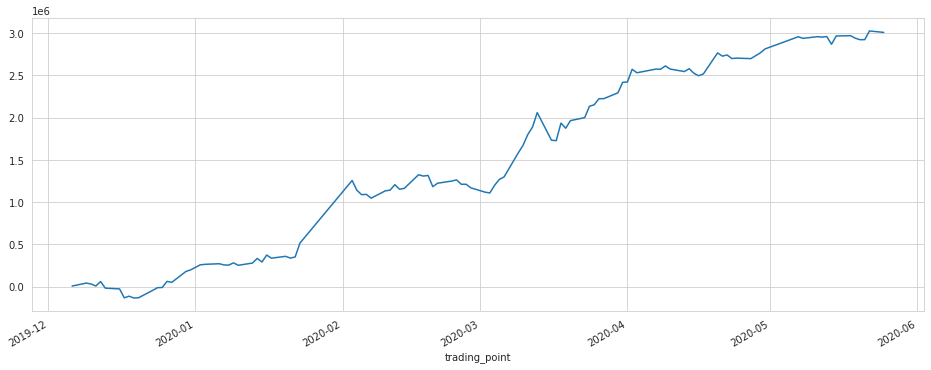

In [4]:
M = ret.diff()
M = M.T.apply(sum)
M = M.loc['2019-12-6':]
M.cumsum().plot(figsize=(16, 6))
#M.to_csv('./TrackRecord.csv')

2020-05-25
time to oSD days
0
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2
SZ50
action 1.000000000
last action -3
SR: 0.18056164847785452
2037094.7576503535
2020-05-25
time to oSD days
0
(2, 50, 23)
(2, 50, 23)
2
(2, 50, 23)
(2, 50, 23)
2
HS300
action 1.000000000
last action 4
SR: 0.22513973724170339
2960456.8593832534


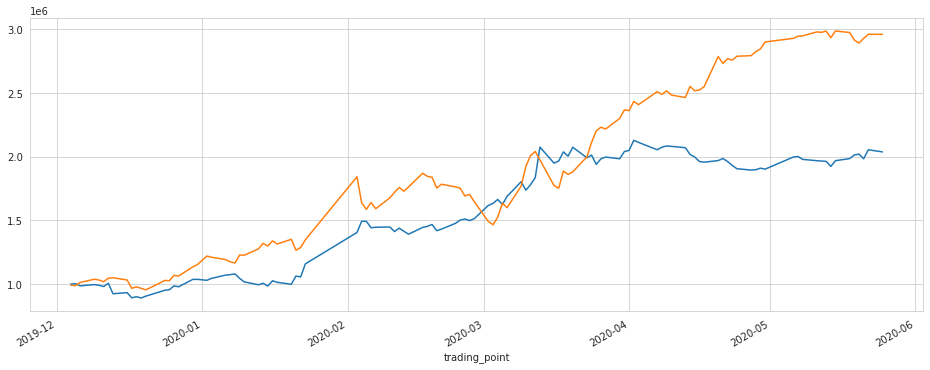

In [5]:
ret = pd.DataFrame()

instrument = ['SZ50', 'HS300']

for _ in instrument:
    print(date.today())
    env = Account('2019-12-01', date.today().strftime('%Y-%m-%d'), _)
    state = env.reset()
    image_shape = state.shape
    Full_Size = env.data_observation.shape[0] - 1
    agent_t = Agent(image_shape, ACTION_SIZE)
    
    try:
        agent_t.load_product_model(_)
    except:
        continue
        
    for i in range(Full_Size):
        action = agent_t.get_exploration_policy(np.expand_dims(state, 0))
        next_state, reward, done = env.step(action, _)
        state = next_state
        
    print(_)
    action = agent_t.get_exploration_policy(np.expand_dims(state, 0))
    print('action %.9f' % action)
    
    tmp = env.plot_data()
    ret[_] = tmp.iloc[:, 0]
    tmp.iloc[:, 0].plot(figsize=(16, 6))
    sharpe = np.mean(tmp['reward'])/np.std(tmp['reward'])
    print('last action %d' % tmp['action'].iloc[-1])
    print("SR:", sharpe)
    print(tmp['value'].iloc[-1])
    #env.factors.to_csv('./fac.csv')
    env.print_trade_record().to_csv('./' + _ + 'track.csv')

In [6]:
L = np.sum(np.maximum(np.sign(tmp['action']), 0))/tmp.shape[0]
L

0.672566371681416

In [7]:
W = np.sum(np.maximum(np.sign(tmp['reward']), 0))/tmp.shape[0]
W

0.5486725663716814